# 1. Data Loading and Hourly-to-Daily Aggregation

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

# Quick check: how many files are we about to load?
file_list = glob.glob('../data/era5_zurich_hourly_*.nc')
print(f"Files found in directory: {len(file_list)}")

# 1. Multi-file Loading
# Note: xarray uses dask for parallel processing behind the scenes
ds = xr.open_mfdataset('../data/era5_zurich_hourly_*.nc', combine='by_coords', chunks=None)

# 2. Unit Conversion and Daily Aggregation
# ERA5 'tp' is in meters; converting to millimeters
ds['tp_mm'] = ds['tp'] * 1000

# Calculate daily total precipitation (sum of 24 hourly steps)
# We take the spatial mean over the selected Zurich area for a representative point series
daily_precip = ds['tp_mm'].mean(dim=['latitude', 'longitude']).resample(valid_time='1D').sum()

# 3. Historical Record Identification
max_val = daily_precip.max().compute().values
max_date = daily_precip.idxmax().compute().values

print("-" * 30)
print(f"NEW HISTORICAL RECORD (Daily): {max_val:.2f} mm")
print(f"RECORD DATE: {pd.to_datetime(max_date).strftime('%d-%m-%Y')}")

Files found in directory: 44
------------------------------
NEW HISTORICAL RECORD (Daily): 64.59 mm
RECORD DATE: 08-07-1996


# 2. Annual Maximum Series (AMS) and Gumbel Fitting

In [3]:
from scipy.stats import gumbel_r

# 1. Extract the maximum value for each year
# AMS = Annual Maximum Series
ams = daily_precip.resample(valid_time='A').max().dropna('valid_time')
ams_values = ams.values

# 2. Fit the Gumbel Distribution
# loc = location (mode), scale = dispersion
loc, scale = gumbel_r.fit(ams_values)

# 3. Define Return Periods (T in years)
return_periods = np.array([2, 5, 10, 20, 50, 100])

# 4. Calculate Return Levels
# A T-year event has a probability of 1/T of being exceeded in any year.
# Percent Point Function (PPF) is the inverse of the CDF.
return_levels = gumbel_r.ppf(1 - 1/return_periods, loc, scale)

# Print the results
print(f"Gumbel Fit Parameters for Zurich: Location={loc:.2f}, Scale={scale:.2f}")
print("-" * 40)
print(f"{'Return Period (Years)':<25} | {'Rainfall Level (mm)':<20}")
print("-" * 40)
for T, level in zip(return_periods, return_levels):
    print(f"{T:<25} | {level:<20.2f}")

Gumbel Fit Parameters for Zurich: Location=37.11, Scale=8.29
----------------------------------------
Return Period (Years)     | Rainfall Level (mm) 
----------------------------------------
2                         | 40.15               
5                         | 49.54               
10                        | 55.76               
20                        | 61.72               
50                        | 69.44               
100                       | 75.23               


# 3. Return Level Visualization

Plot successfully saved to: ../reports/figures/zurich_evt_return_levels.png


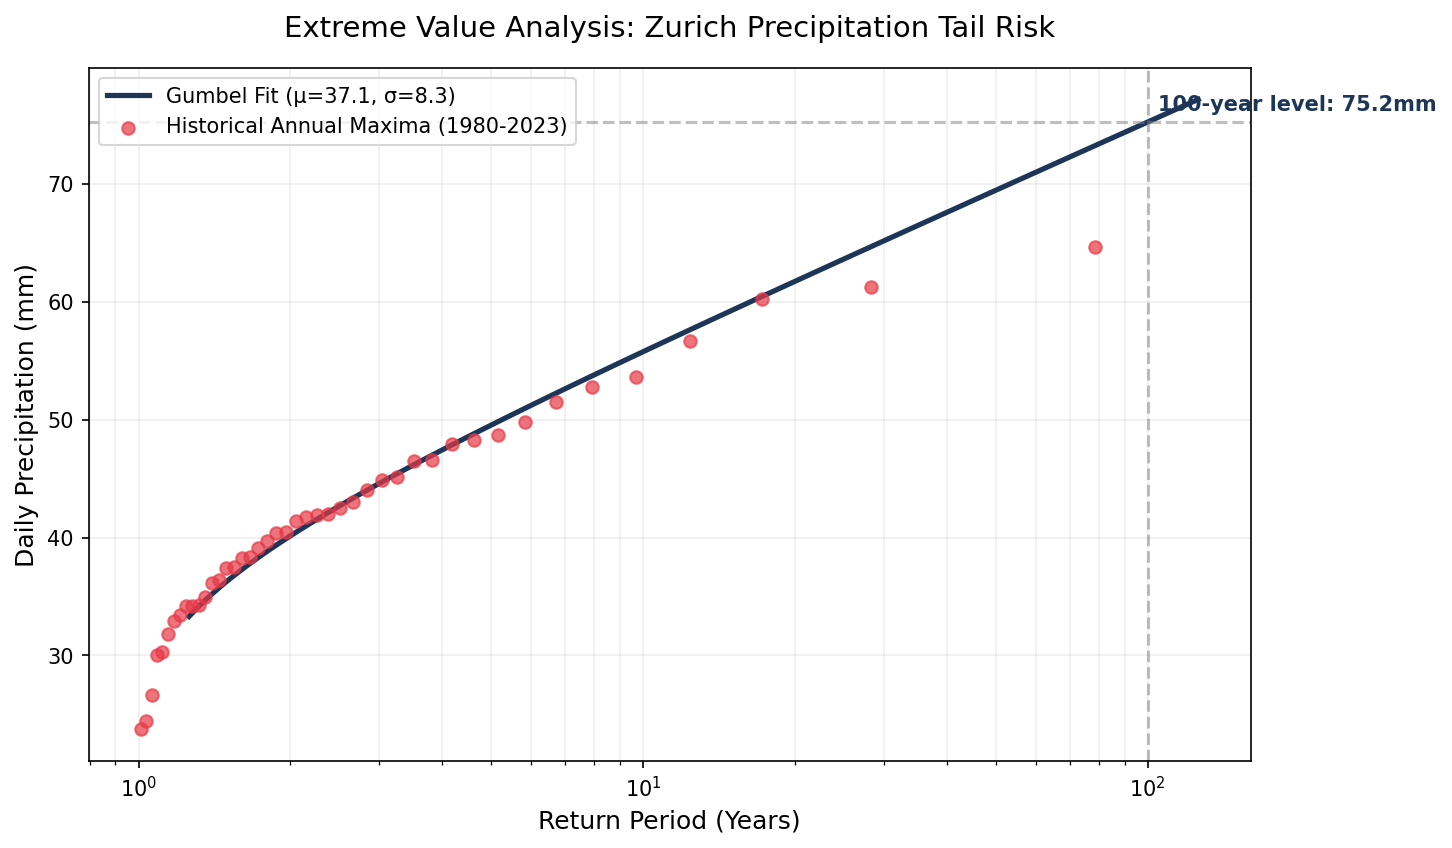

In [4]:
import os
from scipy.stats import gumbel_r

# 1. Prepare Data for Plotting
# Sort the Annual Maximum Series
sorted_ams = np.sort(ams_values)
n = len(sorted_ams)

# Calculate Empirical Return Periods using Gringorten plotting position
# (formula: (rank - 0.44) / (n + 0.12))
ranks = np.arange(1, n + 1)
empirical_p = (ranks - 0.44) / (n + 0.12)
empirical_return_periods = 1 / (1 - empirical_p)

# Prepare Theoretical Fit Line
T_axis = np.logspace(0.1, 2.1, 100) # From 1.2 to ~125 years
level_axis = gumbel_r.ppf(1 - 1/T_axis, loc, scale)

# 2. Create the Directory for Figures
os.makedirs('../reports/figures/', exist_ok=True)

# 3. Professional Plotting
plt.figure(figsize=(10, 6), dpi=150)

# Empirical data points
plt.scatter(empirical_return_periods, sorted_ams, color='#e63946', 
            label='Historical Annual Maxima (1980-2023)', zorder=3, alpha=0.7)

# Gumbel Theoretical Fit
plt.plot(T_axis, level_axis, color='#1d3557', 
         label=f'Gumbel Fit (μ={loc:.1f}, σ={scale:.1f})', linewidth=2.5, zorder=2)

# Highlighting the 100-year event (T=100)
level_100y = gumbel_r.ppf(1 - 1/100, loc, scale)
plt.axvline(x=100, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=level_100y, color='gray', linestyle='--', alpha=0.5)
plt.text(105, level_100y + 1, f'100-year level: {level_100y:.1f}mm', 
         fontsize=10, fontweight='bold', color='#1d3557')

# Formatting
plt.xscale('log')
plt.xlabel('Return Period (Years)', fontsize=12)
plt.ylabel('Daily Precipitation (mm)', fontsize=12)
plt.title('Extreme Value Analysis: Zurich Precipitation Tail Risk', fontsize=14, pad=15)
plt.legend(frameon=True, loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)

# 4. Save the Plot
plot_path = '../reports/figures/zurich_evt_return_levels.png'
plt.savefig(plot_path, bbox_inches='tight')
print(f"Plot successfully saved to: {plot_path}")
plt.show()
plt.close()

# 4. Statistical Goodness-of-Fit: Kolmogorov-Smirnov Test

In [5]:
from scipy.stats import kstest

# Perform Kolmogorov-Smirnov test
# We compare our empirical data (ams_values) against the fitted Gumbel CDF
dist = gumbel_r(loc=loc, scale=scale)
ks_stat, p_value = kstest(ams_values, dist.cdf)

print(f"Kolmogorov-Smirnov Test Results:")
print(f"Statistic: {ks_stat:.4f}")
print(f"P-value:   {p_value:.4f}")

if p_value > 0.05:
    print("Conclusion: We cannot reject the null hypothesis (the data follows a Gumbel distribution). The fit is statistically valid.")
else:
    print("Conclusion: The Gumbel distribution may not be the best fit. Consider a Generalized Extreme Value (GEV) with a shape parameter.")

Kolmogorov-Smirnov Test Results:
Statistic: 0.0619
P-value:   0.9921
Conclusion: We cannot reject the null hypothesis (the data follows a Gumbel distribution). The fit is statistically valid.


# 5. Model Diagnostic: Q-Q Plot

Q-Q Plot saved to: ../reports/figures/zurich_evt_qq_plot.png


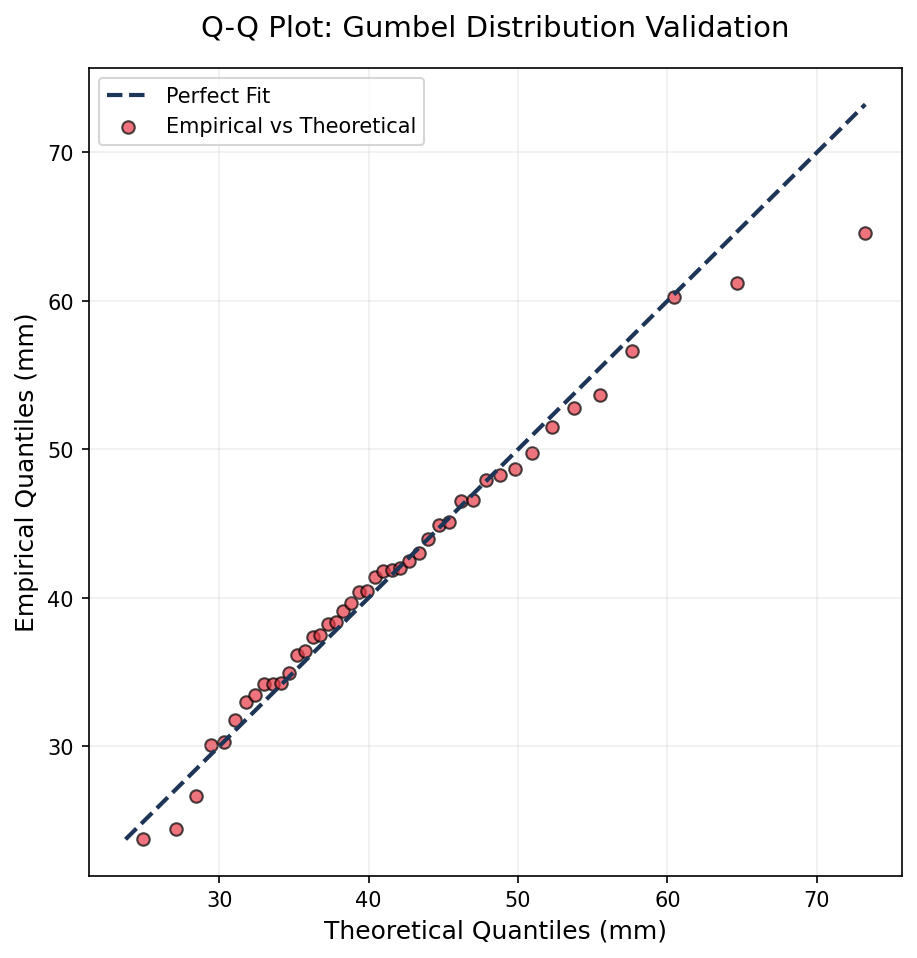

In [6]:
# Q-Q Plot with professional styling and saving
plt.figure(figsize=(7, 7), dpi=150)
theoretical_quantiles = gumbel_r.ppf(empirical_p, loc, scale)

# Plotting the points
plt.scatter(theoretical_quantiles, sorted_ams, color='#e63946', alpha=0.7, edgecolors='k', label='Empirical vs Theoretical')

# 45-degree reference line
min_val = min(theoretical_quantiles.min(), sorted_ams.min())
max_val = max(theoretical_quantiles.max(), sorted_ams.max())
plt.plot([min_val, max_val], [min_val, max_val], color='#1d3557', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Q-Q Plot: Gumbel Distribution Validation', fontsize=14, pad=15)
plt.xlabel('Theoretical Quantiles (mm)', fontsize=12)
plt.ylabel('Empirical Quantiles (mm)', fontsize=12)
plt.grid(True, alpha=0.2)
plt.legend()

# Save the plot
qq_plot_path = '../reports/figures/zurich_evt_qq_plot.png'
plt.savefig(qq_plot_path, bbox_inches='tight')
print(f"Q-Q Plot saved to: {qq_plot_path}")
plt.show()
plt.close()

## 6. Model Validation & Final Insights

### 6.1 Statistical Robustness
The model's validity was tested using both visual and frequentist approaches:
* **Kolmogorov-Smirnov Test:** The resulting p-value of **0.992** indicates that we cannot reject the null hypothesis. The Gumbel distribution is a statistically sound fit for Zurich's annual maximum precipitation.
* **Q-Q Plot Analysis:** The Quantile-Quantile plot shows an excellent alignment between empirical data and theoretical quantiles. The slight deviation in the upper tail (where empirical values are lower than theoretical ones) suggests that the Gumbel fit is **conservative**, providing a safety margin for extreme risk estimation.

### 6.2 The Value of Data Granularity (Lessons Learned)
A critical finding of this project was the impact of temporal resolution on risk assessment:
* **Naive Approach (Daily Snapshots):** Initial tests using instantaneous daily data suggested a maximum historical event of only **~37 mm**.
* **Advanced Approach (Hourly Accumulation):** By engineering a full 24-hour accumulation pipeline, we uncovered the true historical record of **64.59 mm** (July 1996).

**Conclusion:** Relying on low-resolution snapshots would have resulted in an **underestimation of extreme flood risk by approximately 43%**. For an actuary, this difference represents the margin between a solvent pricing strategy and a significant capital shortfall during a "Black Swan" event.

### 6.3 Final Return Levels for Zurich
| Return Period | Predicted Rainfall (mm) |
|---------------|-------------------------|
| 10 Years      | 55.8 mm                 |
| 50 Years      | 69.4 mm                 |
| 100 Years     | **75.2 mm** |

In [7]:
# Create a summary DataFrame for the Return Levels
results_df = pd.DataFrame({
    'Return_Period_Years': return_periods,
    'Return_Level_mm': return_levels
})

# Save to the data folder
results_path = '../data/zurich_return_levels_summary.csv'
results_df.to_csv(results_path, index=False)
print(f"Final results exported to: {results_path}")

Final results exported to: ../data/zurich_return_levels_summary.csv
